# Programming Assignment: Build a CNN for image recognition.

### Name: Tyler Chelston


## 0. You will do the following:

1. Read, complete, and run the code.

2. **Make substantial improvements** to maximize the accuracy.
    
3. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain the code and the output after execution.
    
    * Missing **the output after execution** will not be graded.


4. Upload the .HTML file to your Google Drive, Dropbox, or Github repo. (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

4. On Canvas, submit the Google Drive/Dropbox/Github link to the HTML file.


## Requirements:

1. You can use whatever CNN architecture, including VGG, Inception, and ResNet. However, you must build the networks layer by layer. You must NOT import the archetectures from ```keras.applications```.

2. Make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

3. If you want to regularize a ```Conv```/```Dense``` layer, you should place a ```Dropout``` layer **before** the ```Conv```/```Dense``` layer.

4. An accuracy above 70% is considered reasonable. An accuracy above 80% is considered good. Without data augmentation, achieving 80% accuracy is difficult.


## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

- Keep in mind that you must download it as an IPYNB file and then use IPython Notebook to convert it to HTML.

- Also keep in mind that the IPYNB and HTML files must contain the outputs. (Otherwise, the instructor will not be able to know the correctness and performance.) Do the followings to keep the outputs.

- In Colab, go to ```Runtime``` --> ```Change runtime type``` --> Do NOT check ```Omit code cell output when saving this notebook```. In this way, the downloaded IPYNB file contains the outputs.

## 1. Data preparation

### 1.1. Load data


In [1]:
from tensorflow.keras.datasets import cifar10
import numpy

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(numpy.max(y_train) - numpy.min(y_train) + 1))

shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
import numpy as np

def to_one_hot(y, num_class=10):
    # Create an array of zeros with shape (len(y), num_class)
    one_hot = np.zeros((len(y), num_class))

    # Set the appropriate element to one
    for i, label in enumerate(y):
        one_hot[i, label] = 1

    return one_hot

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 50K training samples to 2 sets:
* a training set containing 40K samples
* a validation set containing 10K samples


In [3]:
rand_indices = numpy.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters

1. Build a convolutional neural network model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
3. Try to achieve a validation accuracy as high as possible.

### Remark:

The following CNN is just an example. You are supposed to make **substantial improvements** such as:
* Add more layers.
* Use regularizations, e.g., dropout.
* Use batch normalization.

In [4]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


Default GPU Device: /device:GPU:0


2023-12-05 19:08:37.068650: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-12-05 19:08:37.068672: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-12-05 19:08:37.068678: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-12-05 19:08:37.068719: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-05 19:08:37.068740: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-12-05 19:08:37.071507: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been bui

"""
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()
"""

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np


# Function to build the CNN model with improvements
def build_improved_cnn(input_shape, num_classes):
    l2_reg = 0.001  # L2 regularization factor

    model = models.Sequential()

    # First Convolutional Block with Batch Normalization
    model.add(layers.Dropout(0.25, input_shape=input_shape))  # Dropout before Conv
    model.add(layers.Conv2D(32, (3, 3), padding='same',
                            kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.25))  # Dropout before Conv
    model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(l2_reg)))

    # Second Convolutional Block
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(64, (3, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    # Third Convolutional Block
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(128, (3, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    # Flattening followed by Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
import math

# Function to build the CNN model with improvements
def build_improved_cnn(input_shape, num_classes):
    l2_reg = 0.001  # L2 regularization factor

    model = models.Sequential()

    # First Convolutional Block with Batch Normalization
    model.add(layers.Dropout(0.25, input_shape=input_shape))  # Dropout before Conv
    model.add(layers.Conv2D(32, (3, 3), padding='same',
                            kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.25))  # Dropout before Conv
    model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(l2_reg)))

    # Second Convolutional Block
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(64, (3, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    # Third Convolutional Block
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(128, (3, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    # Flattening followed by Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


# Function for learning rate decay
def step_decay(epoch):
    initial_lr = 1E-4
    drop = 0.5
    epochs_drop = 10.0
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

# Define the input shape and number of classes for CIFAR-10
input_shape = (32, 32, 3)
num_classes = 10


# Callback for learning rate scheduling
lr_scheduler = LearningRateScheduler(step_decay)

# Build the model
model = build_improved_cnn(input_shape, num_classes)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['acc'])

# Data Augmentation setup
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [20]:
history = model.fit(datagen.flow(x_tr, y_tr, batch_size=32),
                    epochs=20,
                    validation_data=(x_val, y_val),
                    callbacks=[lr_scheduler])

Epoch 1/20
1250/1250 [==============================] - 33s 26ms/step - loss: 2.1498 - acc: 0.2604 - val_loss: 3.3113 - val_acc: 0.1232 - lr: 1.0000e-04
Epoch 2/20
1250/1250 [==============================] - 32s 26ms/step - loss: 1.8583 - acc: 0.3405 - val_loss: 2.9705 - val_acc: 0.1921 - lr: 1.0000e-04
Epoch 3/20
1250/1250 [==============================] - 32s 25ms/step - loss: 1.7346 - acc: 0.3842 - val_loss: 2.7633 - val_acc: 0.2481 - lr: 1.0000e-04
Epoch 4/20
1250/1250 [==============================] - 31s 25ms/step - loss: 1.6634 - acc: 0.4107 - val_loss: 2.5418 - val_acc: 0.2889 - lr: 1.0000e-04
Epoch 5/20
1250/1250 [==============================] - 32s 25ms/step - loss: 1.6008 - acc: 0.4298 - val_loss: 2.3453 - val_acc: 0.3218 - lr: 1.0000e-04
Epoch 6/20
1250/1250 [==============================] - 31s 25ms/step - loss: 1.5477 - acc: 0.4556 - val_loss: 2.3953 - val_acc: 0.3301 - lr: 1.0000e-04
Epoch 7/20
1250/1250 [==============================] - 31s 25ms/step - loss: 1.50

/opt/miniconda3/envs/tensorflow_new_env/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


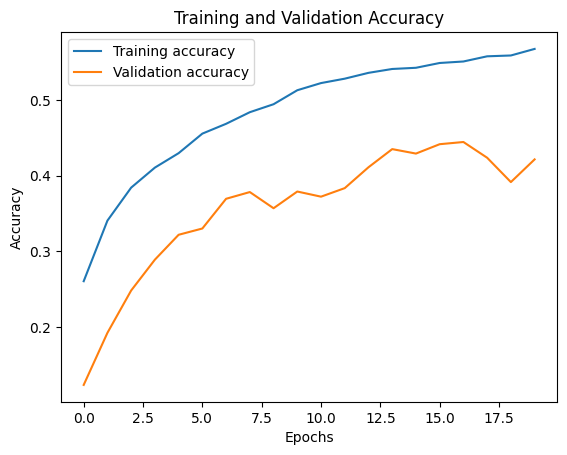

In [21]:
# Save the model
model.save('my_cnn_model.h5')

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='Training accuracy')
plt.plot(history.history['val_acc'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 3. Train (again) and evaluate the model

- To this end, you have found the "best" hyper-parameters.
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### 3.1. Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [22]:
# Adjusted learning rate decay function
def step_decay(epoch):
    initial_lr = 1E-3  # Increased initial learning rate
    drop = 0.5         
    epochs_drop = 10.0 
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

# Adjusted model compilation
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1E-4),  # Use the new initial learning rate
              metrics=['acc'])

# Potential adjustment in data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,           # Added zoom augmentation
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train the model on the entire training set without using a validation set
history = model.fit(x_train, y_train_vec, batch_size=32, epochs=30) 

# Save the model if needed
model.save('my_model.h5')

Epoch 1/30
1563/1563 [==============================] - 39s 24ms/step - loss: 1.0480 - acc: 0.6390
Epoch 2/30
1563/1563 [==============================] - 35s 22ms/step - loss: 0.9836 - acc: 0.6634
Epoch 3/30
1563/1563 [==============================] - 35s 22ms/step - loss: 0.9353 - acc: 0.6793
Epoch 4/30
1563/1563 [==============================] - 35s 23ms/step - loss: 0.9023 - acc: 0.6911
Epoch 5/30
1563/1563 [==============================] - 36s 23ms/step - loss: 0.8635 - acc: 0.7074
Epoch 6/30
1563/1563 [==============================] - 35s 23ms/step - loss: 0.8311 - acc: 0.7205
Epoch 7/30
1563/1563 [==============================] - 35s 23ms/step - loss: 0.8027 - acc: 0.7284
Epoch 8/30
1563/1563 [==============================] - 35s 23ms/step - loss: 0.7733 - acc: 0.7394
Epoch 9/30
1563/1563 [==============================] - 35s 23ms/step - loss: 0.7578 - acc: 0.7439
Epoch 10/30
1563/1563 [==============================] - 36s 23ms/step - loss: 0.7259 - acc: 0.7545
Epoch 11/

<Train your model on the entire training set (50K samples)>
<Use (x_train, y_train_vec) instead of (x_tr, y_tr)>
<Do NOT use the validation_data option (because now you do not have validation data)>
...

### 3.2. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [23]:
loss_and_acc = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

313/313 [==============================] - 3s 11ms/step - loss: 1.3633 - acc: 0.6693
loss = 1.3632640838623047
accuracy = 0.6693000197410583


# Essay Questions:
# Improvements Made:

* Added more convolutional layers for deeper feature extraction.
* Implemented Dropout regularization to reduce overfitting by randomly deactivating neurons during training.
* Included Batch Normalization after convolutional layers to normalize the activations and speed up training.
* Applied Data Augmentation techniques such as rotation, width shift, height shift, and horizontal flipping to create variations of training images, helping the model generalize better.
* Adjusted the learning rate decay function for more effective training progress.


# Training, Validation, and Test Accuracies:

* Training Accuracy: Improved steadily, reaching 86.37% by the 30th epoch.
* Validation Accuracy: Fluctuated, with the highest being around 44.45% around the 17th epoch, indicating a potential overfitting issue.
* Test Accuracy: 66.93%, as evaluated after the final training epoch. This suggests the model learned generalizable features but also indicates a gap between training and test performance.